In [1]:
import os
from pathlib import Path

import cv2
import numpy as np

# Si quieres visualizar luego
import matplotlib.pyplot as plt

# BASE_DIR = carpeta donde está el notebook
BASE_DIR = Path.cwd()
BASE_DIR


PosixPath('/home/mena/workspace/preDbaci')

In [2]:
# Carpeta con el dataset original
ROOT_IN = BASE_DIR / "project-bacilos"

IMG_DIR = ROOT_IN / "images"
LBL_DIR = ROOT_IN / "labels"

# Carpeta de salida para el dataset tileado
ROOT_OUT = BASE_DIR / "project-bacilos-tiled"
OUT_IMG_DIR = ROOT_OUT / "images"
OUT_LBL_DIR = ROOT_OUT / "labels"

OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUT_LBL_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT_IN :", ROOT_IN)
print("IMG_DIR :", IMG_DIR)
print("LBL_DIR :", LBL_DIR)
print("ROOT_OUT:", ROOT_OUT)


ROOT_IN : /home/mena/workspace/preDbaci/project-bacilos
IMG_DIR : /home/mena/workspace/preDbaci/project-bacilos/images
LBL_DIR : /home/mena/workspace/preDbaci/project-bacilos/labels
ROOT_OUT: /home/mena/workspace/preDbaci/project-bacilos-tiled


In [3]:
print("Imágenes:", len(list(IMG_DIR.iterdir())))
print("Labels  :", len(list(LBL_DIR.iterdir())))


Imágenes: 40
Labels  : 40


In [4]:
from typing import List, Tuple

ImageBoxes = List[Tuple[int, float, float, float, float]]  # (cls, x1, y1, x2, y2)

TILE_SIZE = 640  # tamaño de cada tile


def apply_clahe_on_green(img: np.ndarray) -> np.ndarray:
    """
    img: imagen BGR (OpenCV).
    Devuelve imagen BGR de 3 canales, todos a partir del canal G ecualizado con CLAHE.
    """
    g = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_eq = clahe.apply(g)
    img_eq = cv2.merge([g_eq, g_eq, g_eq])
    return img_eq


def load_yolo_labels(label_path: Path, img_w: int, img_h: int) -> ImageBoxes:
    """
    Lee labels YOLO (cls xc yc w h normalizados) y devuelve cajas en píxeles:
    [(cls, x1, y1, x2, y2), ...]
    """
    boxes: ImageBoxes = []
    if not label_path.exists():
        return boxes

    with label_path.open("r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = parts
            cls = int(cls)
            xc, yc, w, h = map(float, (xc, yc, w, h))

            bw = w * img_w
            bh = h * img_h
            x_center = xc * img_w
            y_center = yc * img_h

            x1 = x_center - bw / 2
            y1 = y_center - bh / 2
            x2 = x_center + bw / 2
            y2 = y_center + bh / 2

            boxes.append((cls, x1, y1, x2, y2))

    return boxes


def save_yolo_labels(label_path: Path, boxes: ImageBoxes, tile_w: int, tile_h: int) -> None:
    """
    boxes: [(cls, x1, y1, x2, y2)] en coordenadas del tile (píxeles).
    Guarda en formato YOLO normalizado.
    """
    with label_path.open("w") as f:
        for cls, x1, y1, x2, y2 in boxes:
            bw = x2 - x1
            bh = y2 - y1
            if bw <= 0 or bh <= 0:
                continue

            xc = x1 + bw / 2
            yc = y1 + bh / 2

            xc_n = xc / tile_w
            yc_n = yc / tile_h
            bw_n = bw / tile_w
            bh_n = bh / tile_h

            # descartamos cajas cuyo centro queda fuera del tile
            if not (0.0 <= xc_n <= 1.0 and 0.0 <= yc_n <= 1.0):
                continue

            f.write(f"{cls} {xc_n:.6f} {yc_n:.6f} {bw_n:.6f} {bh_n:.6f}\n")


In [5]:
exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

image_files = sorted([f for f in IMG_DIR.iterdir() if f.suffix.lower() in exts])
print(f"Imágenes encontradas: {len(image_files)}")

total_tiles = 0
total_tiles_with_boxes = 0

for img_path in image_files:
    fname = img_path.name
    base_name = img_path.stem
    lbl_path = LBL_DIR / f"{base_name}.txt"

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ No se pudo leer: {img_path}")
        continue

    # 1) CLAHE en canal verde
    img_eq = apply_clahe_on_green(img)
    H, W = img_eq.shape[:2]

    # 2) Cargar cajas YOLO originales
    boxes = load_yolo_labels(lbl_path, W, H)

    local_tile_id = 0
    for y0 in range(0, H, TILE_SIZE):
        for x0 in range(0, W, TILE_SIZE):
            x1 = x0 + TILE_SIZE
            y1 = y0 + TILE_SIZE

            # ignoramos tiles que se salgan del borde
            if x1 > W or y1 > H:
                continue

            tile = img_eq[y0:y1, x0:x1]

            # Ajustar cajas que intersectan este tile
            tile_boxes: ImageBoxes = []
            for cls, bx1, by1, bx2, by2 in boxes:
                ix1 = max(bx1, x0)
                iy1 = max(by1, y0)
                ix2 = min(bx2, x1)
                iy2 = min(by2, y1)

                if ix2 <= ix1 or iy2 <= iy1:
                    continue  # sin intersección

                rx1 = ix1 - x0
                ry1 = iy1 - y0
                rx2 = ix2 - x0
                ry2 = iy2 - y0
                tile_boxes.append((cls, rx1, ry1, rx2, ry2))

            # Solo guardamos tiles con al menos 1 bacilo
            if not tile_boxes:
                continue

            out_img_name = f"{base_name}_t{local_tile_id}.jpg"
            out_lbl_name = f"{base_name}_t{local_tile_id}.txt"

            cv2.imwrite(str(OUT_IMG_DIR / out_img_name), tile)
            save_yolo_labels(OUT_LBL_DIR / out_lbl_name, tile_boxes, TILE_SIZE, TILE_SIZE)

            local_tile_id += 1
            total_tiles += 1
            total_tiles_with_boxes += 1

    print(f"{fname}: {local_tile_id} tiles con bacilos generados.")

print("\n✅ Preprocesamiento terminado.")
print(f"   Total de tiles generados (con bacilos): {total_tiles_with_boxes}")


Imágenes encontradas: 40
016c9b59-35.bmp: 12 tiles con bacilos generados.
04848d33-25.bmp: 11 tiles con bacilos generados.
0adbfb8e-33.bmp: 12 tiles con bacilos generados.
0c9d7201-2.bmp: 10 tiles con bacilos generados.
0efb66b2-13.bmp: 11 tiles con bacilos generados.
13eaa6f8-22.bmp: 12 tiles con bacilos generados.
17a8e102-23.bmp: 12 tiles con bacilos generados.
19db762d-17.bmp: 11 tiles con bacilos generados.
1de8845e-3.bmp: 9 tiles con bacilos generados.
3028c42f-7.bmp: 10 tiles con bacilos generados.
3baf91bd-18.bmp: 12 tiles con bacilos generados.
48ac55f3-4.bmp: 11 tiles con bacilos generados.
48b1d133-37.bmp: 12 tiles con bacilos generados.
4b0a37b0-11.bmp: 12 tiles con bacilos generados.
4dd11fcb-12.bmp: 12 tiles con bacilos generados.
5d12626d-14.bmp: 11 tiles con bacilos generados.
5e19e1f0-5.bmp: 10 tiles con bacilos generados.
5e4af9db-21.bmp: 12 tiles con bacilos generados.
684b4d4b-26.bmp: 12 tiles con bacilos generados.
69443ff3-32.bmp: 12 tiles con bacilos generados.
6

Ejemplo: d5e067a9-39_t5.jpg


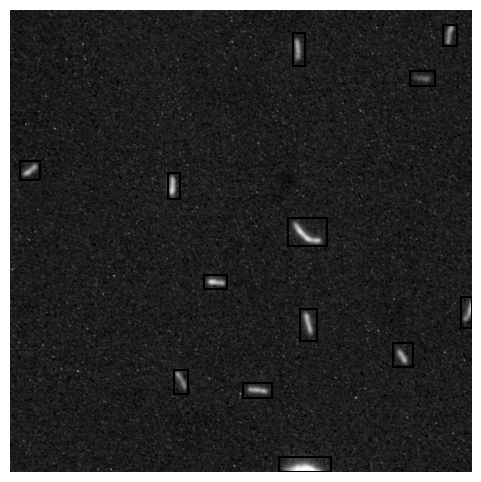

In [6]:
# Elegimos un tile cualquiera
sample_img_path = next(OUT_IMG_DIR.iterdir())
sample_lbl_path = OUT_LBL_DIR / f"{sample_img_path.stem}.txt"

print("Ejemplo:", sample_img_path.name)

tile = cv2.imread(str(sample_img_path))
tile_rgb = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

# Cargar cajas del tile (ya en formato YOLO del tile)
boxes_tile: ImageBoxes = []
with sample_lbl_path.open("r") as f:
    for line in f:
        cls, xc, yc, w, h = map(float, line.strip().split())
        cls = int(cls)
        bw = w * TILE_SIZE
        bh = h * TILE_SIZE
        x_center = xc * TILE_SIZE
        y_center = yc * TILE_SIZE
        x1 = x_center - bw / 2
        y1 = y_center - bh / 2
        x2 = x_center + bw / 2
        y2 = y_center + bh / 2
        boxes_tile.append((cls, x1, y1, x2, y2))

# Dibujar
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(tile_rgb)
for cls, x1, y1, x2, y2 in boxes_tile:
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         fill=False, linewidth=1.5)
    ax.add_patch(rect)
ax.set_axis_off()
plt.show()


In [7]:
from pathlib import Path
import random, shutil

ROOT_TILED = BASE_DIR / "project-bacilos-tiled"
IMG_DIR_T = ROOT_TILED / "images"
LBL_DIR_T = ROOT_TILED / "labels"

ROOT_SPLIT = BASE_DIR / "project-bacilos-tiled-split"
IMG_TRAIN = ROOT_SPLIT / "images" / "train"
IMG_VAL   = ROOT_SPLIT / "images" / "val"
LBL_TRAIN = ROOT_SPLIT / "labels" / "train"
LBL_VAL   = ROOT_SPLIT / "labels" / "val"

for d in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL]:
    d.mkdir(parents=True, exist_ok=True)

tiles = sorted([p for p in IMG_DIR_T.iterdir() if p.suffix.lower() in (".jpg", ".png", ".bmp", ".tif", ".tiff")])
len(tiles)


459

In [8]:
random.seed(42)
random.shuffle(tiles)

n_total = len(tiles)
n_train = int(0.8 * n_total)
train_tiles = tiles[:n_train]
val_tiles   = tiles[n_train:]

print("Train:", len(train_tiles), "Val:", len(val_tiles))


Train: 367 Val: 92


In [9]:
def move_pair(img_path: Path, dst_img_dir: Path, dst_lbl_dir: Path):
    base = img_path.stem
    lbl_path = LBL_DIR_T / f"{base}.txt"
    if not lbl_path.exists():
        return
    shutil.copy2(img_path, dst_img_dir / img_path.name)
    shutil.copy2(lbl_path, dst_lbl_dir / lbl_path.name)

for p in train_tiles:
    move_pair(p, IMG_TRAIN, LBL_TRAIN)

for p in val_tiles:
    move_pair(p, IMG_VAL, LBL_VAL)

print("Hecho.")


Hecho.


In [10]:
print("Train imgs:", len(list(IMG_TRAIN.iterdir())))
print("Val imgs  :", len(list(IMG_VAL.iterdir())))


Train imgs: 367
Val imgs  : 92


In [11]:
import shutil

ZIP_PATH = BASE_DIR / "project-bacilos-tiled-split.zip"

if ZIP_PATH.exists():
    ZIP_PATH.unlink()

shutil.make_archive(
    base_name=str(ZIP_PATH.with_suffix("")),
    format="zip",
    root_dir=str(ROOT_SPLIT)
)

ZIP_PATH


PosixPath('/home/mena/workspace/preDbaci/project-bacilos-tiled-split.zip')